# Building A Linear Regression with PySpark and MLlib
reference: https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a

In [1]:
!pip install kaggle >/dev/null
!pip install mleap > /dev/null

Install MLeap:
spark-shell --packages ml.combust.mleap:mleap-spark_2.11:0.10.0

In [7]:
from googleapiclient.discovery import build
import io, os
import zipfile
import pandas as pd
import six
try:
  from pathlib import Path
except ImportError:
  from pathlib2 import Path  # python 2 backport

In [12]:
# Write kaggle.json to ~/.kaggle/
filename = "/root/.kaggle/kaggle.json"

Path(os.path.dirname(filename)).mkdir(exist_ok=True)
!cp kaggle.json {filename}
os.chmod(filename, 600)

## Boston Housing Dataset
reference: https://www.kaggle.com/c/boston-housing/data

In [5]:
dataset = 'boston-housing'

In [8]:
folder = '/content/datalab/datasets/'+dataset
Path(os.path.dirname(folder)).mkdir(exist_ok=True)
if not os.path.isdir(folder):
  os.mkdir(folder)
os.chdir(folder)
os.system('kaggle competitions download -c '+dataset)
for file in os.listdir(folder):
  filename, file_extension = os.path.splitext(file)
  if file_extension == '.zip':
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

In [9]:
training_dataset=os.path.abspath('train.csv')
print(training_dataset)

/content/datalab/datasets/boston-housing/train.csv


In [10]:
!hdfs dfs -mkdir -p /hdfs/mydataproc-m/user/root/datasets
!hadoop fs -put {training_dataset} /hdfs/mydataproc-m/user/root/datasets
!hadoop fs -ls /hdfs/mydataproc-m/user/root/datasets

18/11/01 17:28:46 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.10-hadoop2
18/11/01 17:28:49 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.10-hadoop2
put: `/hdfs/mydataproc-m/user/root/datasets/train.csv': File exists
18/11/01 17:28:51 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.10-hadoop2
Found 1 items
-rw-r--r--   2 root hadoop      24128 2018-11-01 15:59 /hdfs/mydataproc-m/user/root/datasets/train.csv


In [11]:
house_pddf=pd.read_csv(training_dataset)
house_pddf.head()

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


In [12]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
#sc= SparkContext()
sqlContext = SQLContext(sc)

In [13]:
house_df=sqlContext.createDataFrame(house_pddf)
house_df.take(1)

[Row(ID=1, crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.5379999999999999, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, black=396.9, lstat=4.98, medv=24.0)]

In [14]:
house_df.cache()
house_df.printSchema()

root
 |-- ID: long (nullable = true)
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: long (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: long (nullable = true)
 |-- tax: long (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- black: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



In [15]:
house_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
ID,333,250.95195195195194,147.85943780185974,1,506
crim,333,3.3603414714714708,7.352271836781106,0.00632,73.5341
zn,333,10.68918918918919,22.67476179661821,0.0,100.0
indus,333,11.293483483483465,6.998123104477312,0.74,27.74
chas,333,0.06006006006006006,0.23795564281644835,0,1
nox,333,0.5571441441441443,0.114954508302893,0.385,0.871
rm,333,6.2656186186186185,0.7039515757334478,3.5610000000000004,8.725
age,333,68.22642642642641,28.13334360562339,6.0,100.0
dis,333,3.7099336336336326,1.9811230514407,1.1296,10.7103


/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


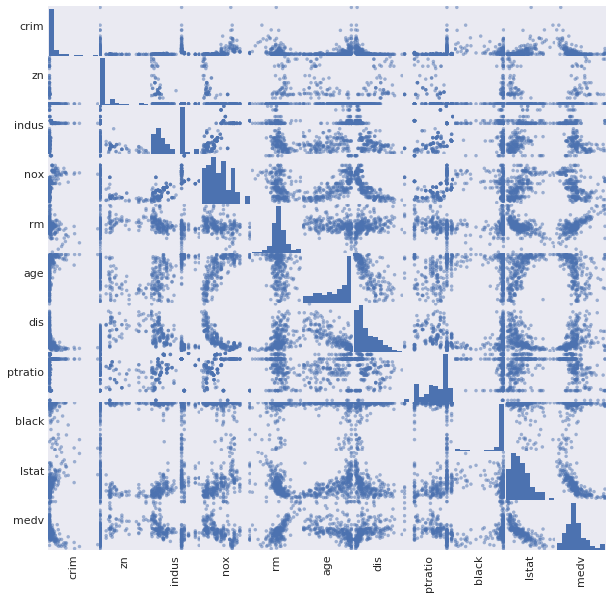

In [16]:
numeric_features = [t[0] for t in house_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = house_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [17]:
for i in house_df.columns:
    if not( isinstance(house_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to MV for ", i, house_df.stat.corr('medv',i))

('Correlation to MV for ', 'ID', -0.22169418651611728)
('Correlation to MV for ', 'crim', -0.40745432357325956)
('Correlation to MV for ', 'zn', 0.34484197569664304)
('Correlation to MV for ', 'indus', -0.47393197065920367)
('Correlation to MV for ', 'chas', 0.20438998859918697)
('Correlation to MV for ', 'nox', -0.4130541519920779)
('Correlation to MV for ', 'rm', 0.6895980892872151)
('Correlation to MV for ', 'age', -0.3588882740619018)
('Correlation to MV for ', 'dis', 0.24942226829396386)
('Correlation to MV for ', 'rad', -0.3522508242456344)
('Correlation to MV for ', 'tax', -0.4480776944007042)
('Correlation to MV for ', 'ptratio', -0.48137595552491796)
('Correlation to MV for ', 'black', 0.3366595553215576)
('Correlation to MV for ', 'lstat', -0.7386000348786338)
('Correlation to MV for ', 'medv', 1.0)


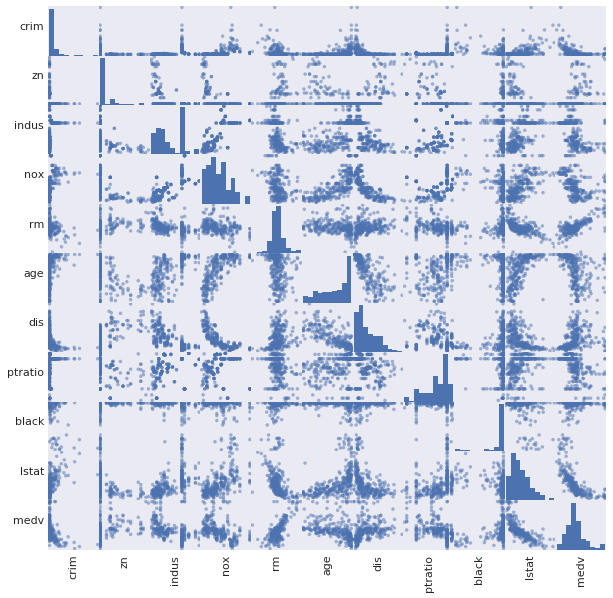

In [18]:
numeric_features = [t[0] for t in house_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = house_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [19]:
house_df.columns

['ID',
 'crim',
 'zn',
 'indus',
 'chas',
 'nox',
 'rm',
 'age',
 'dis',
 'rad',
 'tax',
 'ptratio',
 'black',
 'lstat',
 'medv']

In [20]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat'], outputCol = 'features')
vhouse_df = vectorAssembler.transform(house_df)
vhouse_df = vhouse_df.select(['features', 'medv'])
vhouse_df.show(3)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.03236999999999...|33.4|
+--------------------+----+
only showing top 3 rows



In [21]:
splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [22]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='medv', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.0216748807150132,-0.052981256503904894,3.2644720774244282,-2.9084041614776472,3.4296643398319824,-0.0013904193540803871,-0.763279251611491,0.017126146189633713,0.0,-0.5643421030711261,0.008923871838820848,-0.655774001643866]
Intercept: 21.2394043219


In [23]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 4.906622
r2: 0.710571


In [24]:
train_df.describe().show()

+-------+------------------+
|summary|              medv|
+-------+------------------+
|  count|               248|
|   mean|22.832661290322587|
| stddev| 9.138800460701598|
|    min|               5.0|
|    max|              50.0|
+-------+------------------+



In [25]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","medv","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="medv",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|  30.9388417606141|24.0|[0.00632,18.0,2.3...|
|30.797185530308095|29.1|[0.01439,60.0,2.9...|
|  25.3622289078499|33.0|[0.01951,17.5,1.3...|
| 38.91871166138411|50.0|[0.02009,95.0,2.6...|
|26.708525057331876|24.7|[0.02055,85.0,0.7...|
+------------------+----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.695344


In [26]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 5.11717


In [27]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 11
objectiveHistory: [0.49999999999999956, 0.43383368365231756, 0.2508483720715796, 0.22777807287829688, 0.19481269949090768, 0.18833356825223282, 0.1866646081984174, 0.1838294767818857, 0.18314083608605908, 0.18290621887253514, 0.1827938222799784]
+--------------------+
|           residuals|
+--------------------+
|   4.890465432541859|
|  0.9184562507910243|
|0.012317019376688165|
|  1.2729921962288202|
|-0.10428231565110835|
|  -3.558744770527099|
|  0.4487680180386704|
| -2.4252399245741323|
|   3.206352468585713|
|  1.5346775749980068|
|  -4.287456513390325|
|  10.793834716614015|
|  -2.255535575267327|
| -0.6061828624075005|
|   -3.22160121213712|
|  -4.804463490371084|
| -2.0851535844781353|
| -4.3038474828592115|
|  -0.660092875638135|
|   0.905261919770755|
+--------------------+
only showing top 20 rows



In [28]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","medv","features").show()

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|  30.9388417606141|24.0|[0.00632,18.0,2.3...|
|30.797185530308095|29.1|[0.01439,60.0,2.9...|
|  25.3622289078499|33.0|[0.01951,17.5,1.3...|
| 38.91871166138411|50.0|[0.02009,95.0,2.6...|
|26.708525057331876|24.7|[0.02055,85.0,0.7...|
|29.600738419872165|23.5|[0.03584,80.0,3.3...|
|24.659918266405274|20.6|[0.04294,28.0,15....|
| 26.90749549913211|23.9|[0.04462,25.0,4.8...|
|30.901939723499993|30.3|[0.04666,80.0,1.5...|
| 24.73740186348146|23.9|[0.05058999999999...|
| 27.79879294750953|26.6|[0.05735,0.0,4.49...|
|31.631181567466765|37.2|[0.0578,0.0,2.46,...|
| 30.26643772409574|29.4|[0.06663999999999...|
|19.807184600384602|22.0|[0.06899,0.0,25.6...|
|25.005925017937013|23.2|[0.07022,0.0,4.05...|
|20.255894673550223|20.3|[0.07165,0.0,25.6...|
|29.715853550203956|32.5|[0.10008,0.0,2.46...|
|22.644310702051612|20.0|[0.10153,0.0,12.8...|
|27.042129126